<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/notebooks/Titanic_prediction_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 타이타닉 생존자 예측 분석(Titanic: Machine Learning from Disaster)

: 데이터(탑승객의 나이, 성별, 좌석 등급 등)를 기반으로 해당 승객의 생존 여부를 예측하는 이진 분류 모델 개발

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


* 먼저 분석에 필요한 라이브러리를 불러오고 데이터를 로드
* 데이터 전처리의 편의를 위해 Train 데이터와 Test 데이터를 합쳐서 진행

In [24]:
warnings.filterwarnings('ignore')

# 데이터 로드
train_url = "https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv"
test_url = "https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv"

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)


In [21]:
display(train_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


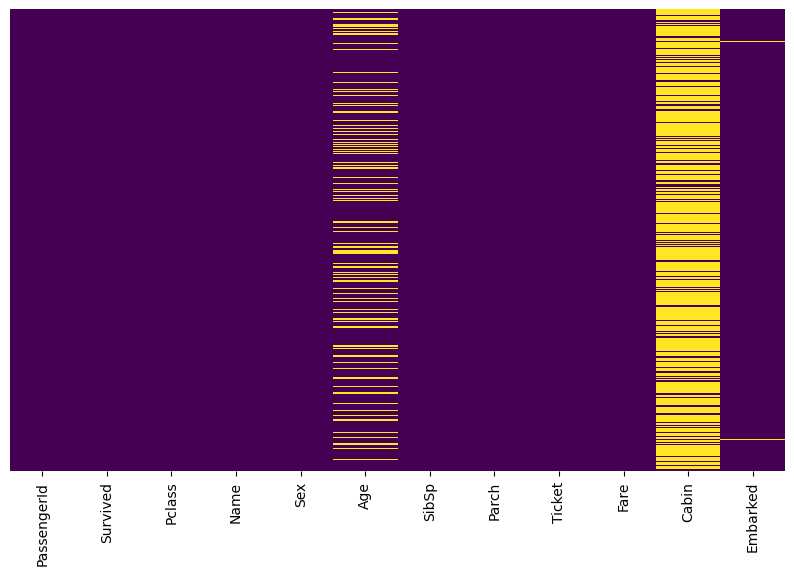

In [22]:
# 결측치 확인
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.show()

: Age와 Cabin에서 결측치 확인

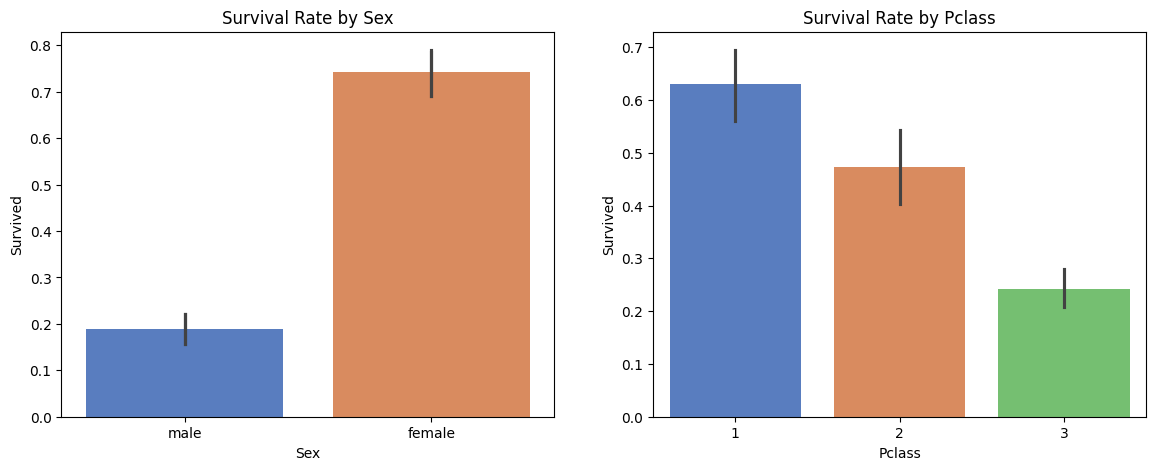

In [25]:
# 3. 주요 변수와 생존율의 관계 확인
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x='Sex', y='Survived', data=train_df, ax=ax[0], palette='muted')
ax[0].set_title('Survival Rate by Sex')

sns.barplot(x='Sex', y='Survived', data=train_df, ax=ax[0], palette='muted')
ax[0].set_title('Survival Rate by Sex')

# 좌석 등급(Pclass)에 따른 생존율
sns.barplot(x='Pclass', y='Survived', data=train_df, ax=ax[1], palette='muted')
ax[1].set_title('Survival Rate by Pclass')
plt.show()

: 여성이 남성보다 높은 생존율, 좌석 등급이 높을 수록 생존율 높았음

In [26]:
# 승객 이름 컬럼 확인
print(train_df['Name'].head(20))

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [27]:
# 쉼표 뒤, 마침표 앞 단어 추출 및 빈도 계산
temp_titles = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print(temp_titles.value_counts())

Name
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


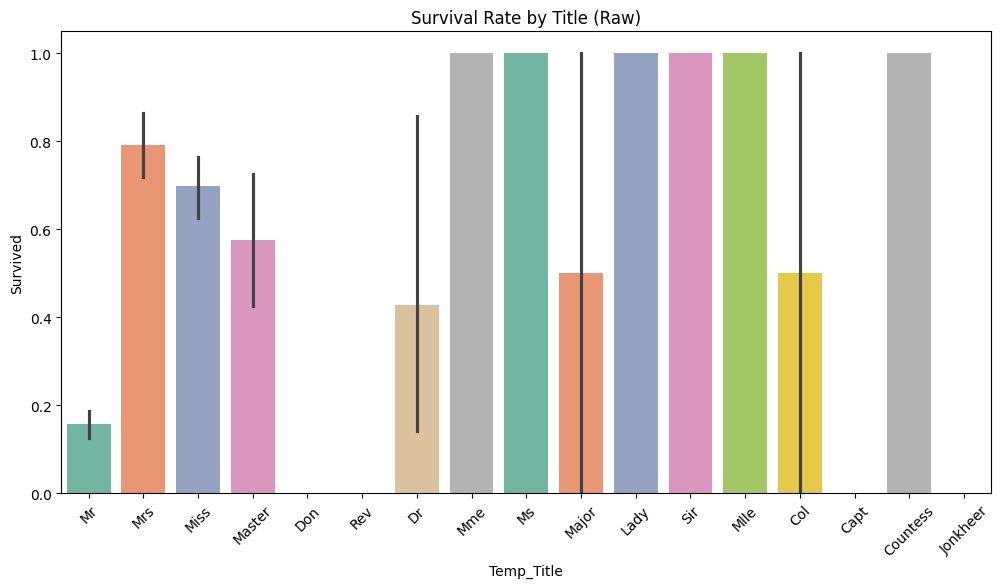

In [28]:
# 호칭별 생존율 시각화
train_df['Temp_Title'] = temp_titles
plt.figure(figsize=(12, 6))
sns.barplot(x='Temp_Title', y='Survived', data=train_df, palette='Set2')
plt.title('Survival Rate by Title (Raw)')
plt.xticks(rotation=45)
plt.show()

: 1. Mrs, Miss의 생존율이 높다.
2. Master (남자 아이)의 생존율이 Mr (성인 남성)보다 훨씬 높다.


In [11]:
# 전처리를 위해 데이터 병합 (Survived 컬럼은 분리해둠)
target = train_df['Survived']
train_df = train_df.drop('Survived', axis=1)
combined_df = pd.concat([train_df, test_df], ignore_index=True)

print(f"전체 데이터 크기: {combined_df.shape}")
combined_df.head()

전체 데이터 크기: (1309, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
# 이름에는 신분과 성별, 결혼 여부를 알 수 있는 호칭이 포함
# 이를 추출하여 Title 이라는 새로운 변수를 만들어 추가
# 이름에서 호칭 추출 (정규표현식 사용)
combined_df['Title'] = combined_df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))

# 호칭 범주화 (비슷한 호칭끼리 묶기)
combined_df['Title'] = combined_df['Title'].replace(['Ms', 'Mlle'], 'Miss')
combined_df['Title'] = combined_df['Title'].replace(['Mme', 'Lady', 'Dona'], 'Mrs')
combined_df['Title'] = combined_df['Title'].replace(['Sir', 'Jonkheer', 'Don', 'Countess', 'Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Rare')

print(combined_df['Title'].value_counts())

Title
Mr        757
Miss      264
Mrs       200
Master     61
Rare       27
Name: count, dtype: int64


In [30]:
# 가족 규모 및 혼자 탑승 여부
# 형제 및 배우자 수와 부모/자녀 수를 합쳐 FamilySize 추가.
# 혼자 여부도 체크

# 가족 수 = 본인(1) + 형제자매 + 부모자녀
combined_df['FamilySize'] = combined_df['SibSp'] + combined_df['Parch'] + 1

# 혼자 탑승했는지 여부 (1: 혼자, 0: 가족 있음)
combined_df['IsAlone'] = (combined_df['FamilySize'] == 1).astype(int)

# 분석에 불필요해진 원본 컬럼 및 식별자 제거
drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch']
combined_df_processed = combined_df.drop(columns=drop_cols)

print("--- 파생 변수 생성 후 컬럼 목록 ---")
print(combined_df_processed.columns.tolist())

--- 파생 변수 생성 후 컬럼 목록 ---
['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']


### Logistic Regression 하이퍼파라미터 튜닝

In [31]:
# 3.1. 결측치 채우기 전략
# Embarked: 가장 많이 탑승한 항구('S')로 채웁니다.

# Fare: 3등석 승객의 요금 중앙값으로 채웁니다.

# Age: 단순히 전체 평균을 쓰는 대신, 앞서 만든 Title(호칭)별 중앙값을 사용하여 더 정교하게 채웁니다. (예: 'Master'는 어린이, 'Mr'는 성인 남성)

# Python

# 1. Embarked 결측치: 최빈값 'S'
combined_df_processed['Embarked'] = combined_df_processed['Embarked'].fillna('S')

# 2. Fare 결측치: 3등석 중앙값
fare_median = combined_df_processed[combined_df_processed['Pclass'] == 3]['Fare'].median()
combined_df_processed['Fare'] = combined_df_processed['Fare'].fillna(fare_median)

# 3. Age 결측치: Title별 중앙값으로 그룹화하여 채우기
age_median_by_title = combined_df_processed.groupby('Title')['Age'].transform('median')
combined_df_processed['Age'] = combined_df_processed['Age'].fillna(age_median_by_title)

# 결측치가 남았는지 확인
print(combined_df_processed.isnull().sum())

Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilySize    0
IsAlone       0
dtype: int64


In [32]:
# 3.2. 전처리 파이프라인(Pipeline) 구축
# 수치형 변수는 **스케일링(StandardScaler)**을, 범주형 변수는 **원-핫 인코딩(OneHotEncoder)**을 적용해야 합니다. ColumnTransformer를 사용하여 이를 자동화합니다.


# 학습 데이터와 테스트 데이터 다시 분리
X = combined_df_processed.iloc[:len(train_df)]
X_test_final = combined_df_processed.iloc[len(train_df):]
y = target

# 변수 타입별 리스트
numeric_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']

# 파이프라인 정의
preprocessor = ColumnTransformer(
    transformers=[
        # 수치형 변수: 정규화 (StandardScaler)
        ('num', StandardScaler(), numeric_features),
        # 범주형 변수: 원-핫 인코딩
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("전처리 파이프라인 구축 완료")

전처리 파이프라인 구축 완료


In [33]:
# 4. 모델링 및 성능 비교
# 다양한 모델을 사용하여 성능을 비교해 봅니다. 여기서는 Logistic Regression, Random Forest, XGBoost 세 가지 모델을 테스트합니다.


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델별 파이프라인 생성 및 성능 평가
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42, n_estimators=100)),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

results = []

for name, model in models:
    # 전처리 -> 모델학습 파이프라인 연결
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # 학습 및 예측
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)

    # 정확도 계산
    acc = accuracy_score(y_val, preds)
    results.append((name, acc))
    print(f"{name}: {acc:.4f}")

Logistic Regression: 0.8436
Random Forest: 0.7654
XGBoost: 0.7989


In [34]:
# 하이퍼파라미터 튜닝: XGBoost, Logistic Regression

logistic_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

# 탐색할 파라미터 조합 설정
# C: 규제 강도 (작을수록 강한 규제)
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'] # 규제 유형
}

# 그리드 서치 실행
grid_search_lr = GridSearchCV(logistic_pipeline, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X, y) # 전체 학습 데이터 사용

print(f"최적 파라미터: {grid_search_lr.best_params_}")
print(f"최고 교차 검증 정확도 (Logistic Regression): {grid_search_lr.best_score_:.4f}")

최적 파라미터: {'classifier__C': 100, 'classifier__penalty': 'l1'}
최고 교차 검증 정확도 (Logistic Regression): 0.8305


In [35]:
# Random Forest를 선택하여 튜닝 진행
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

# 탐색할 파라미터 조합 설정 (트리수, 깊이, 노드 분할 샘플 수)
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5]
}

# 그리드 서치 실행 (5-Fold 교차 검증)
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y) # 전체 학습 데이터 사용

print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최고 교차 검증 정확도: {grid_search.best_score_:.4f}")

최적 파라미터: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
최고 교차 검증 정확도: 0.8339


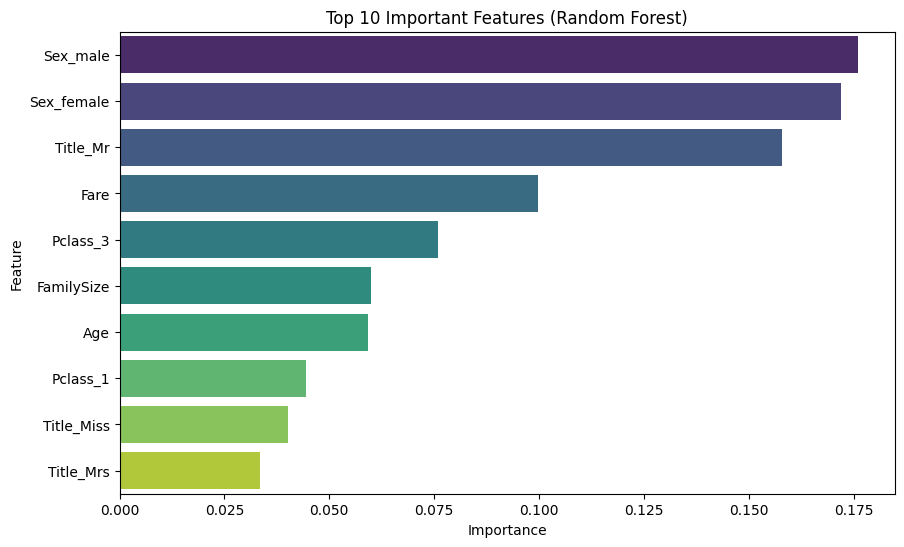

In [36]:
# 피처 중요도(Feature Importance) 확인
# 모델이 예측을 할 때 어떤 변수를 중요하게 생각했는지 시각화합니다. 이는 분석 결과의 설득력을 높여줍니다.

# 최적의 모델 추출
best_model = grid_search.best_estimator_.named_steps['classifier']
feature_names = (numeric_features +
                 list(grid_search.best_estimator_.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

importances = best_model.feature_importances_

# 시각화용 데이터프레임 생성
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 10 Important Features (Random Forest)')
plt.show()